# Machine Learning Challenge
## Sentiment Analysis for Text => Toxic Comment Classification

In [136]:
__author__ = "Carolina Jiménez Moreno <cjimenezm0794@gmail.com>"
__version__ = "1.0.0"

In [137]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import libraries

In [138]:
# pre-processing data
import re
import nltk
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
# training model
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Load dataset

In [139]:
train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")
test_labels_df = pd.read_csv("/content/drive/MyDrive/test_labels.csv")

In [140]:
target_classes = train_df.columns[2:]

## Explore data

In [141]:
# Let's first take a look at the structure of training data.
train_df.head(13)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [142]:
# The dataset has 159571 rows and 8 columns.
# Of these 8 columns, 6 are the classes to predict.
train_df.shape

(159571, 8)

In [143]:
# Let's also take a look at the validation dataset.
# Here we only have the text content.
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [144]:
# The dataset has 153164 rows and 2 columns.
test_df.shape

(153164, 2)

In [145]:
# Let's create a new column to represent positive and negative comments
train_df["label"] = train_df.iloc[:,2:8].apply(lambda x: "positive" if (sum(x)==0) else "negative", axis=1)
train_df.head(13)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,positive
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,positive
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,positive
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,positive
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,positive
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,positive
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,negative
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,positive
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,positive
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,positive


In [146]:
# Let's check how many items has each label
# The data set is unbalanced. For positive comments there are many data. Let's then proceed to match these data.
train_df["label"].value_counts()

positive    143346
negative     16225
Name: label, dtype: int64

In [147]:
# Let's create a data copy
data = train_df.copy()

In [148]:
# Get randomly indices of rows with positive comments
idx = data.loc[data['label']=="positive"].sample(n=127121).index
# Let's remove these indices from dataset
train_data = data.drop(idx)
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,negative
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,positive
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,negative
15,00078f8ce7eb276d,"""\n\nJuelz Santanas Age\n\nIn 2002, Juelz Sant...",0,0,0,0,0,0,positive
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,negative


In [149]:
# We now see that the data for positive and negative comments has already been distributed
train_data["label"].value_counts()

negative    16225
positive    16225
Name: label, dtype: int64

### Classes

Text(0.5, 1.0, 'identity_hate')

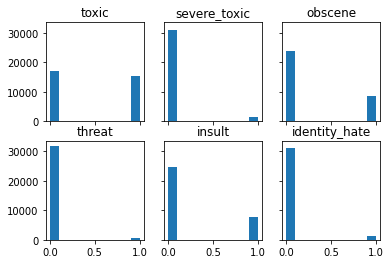

In [150]:
# Classes have binary values. 0 when it does not apply and 1 when it does apply.
# Let's visualize frequency histogram of each of classes in order to see periodicity of values.
figure, axs = plt.subplots(2,3, sharey=True, sharex=True)
axs[0, 0].hist(train_data['toxic'])
axs[0, 0].set_title("toxic")
axs[0, 1].hist(train_data['severe_toxic'])
axs[0, 1].set_title("severe_toxic")
axs[0, 2].hist(train_data['obscene'])
axs[0, 2].set_title("obscene")
axs[1, 0].hist(train_data['threat'])
axs[1, 0].set_title("threat")
axs[1, 1].hist(train_data['insult'])
axs[1, 1].set_title("insult")
axs[1, 2].hist(train_data['identity_hate'])
axs[1, 2].set_title("identity_hate")

In [151]:
train_data[target_classes].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

### Missing values

In [152]:
# Before we continue, let's make sure that the dataset does not have null or empty data.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32450 entries, 6 to 159569
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             32450 non-null  object
 1   comment_text   32450 non-null  object
 2   toxic          32450 non-null  int64 
 3   severe_toxic   32450 non-null  int64 
 4   obscene        32450 non-null  int64 
 5   threat         32450 non-null  int64 
 6   insult         32450 non-null  int64 
 7   identity_hate  32450 non-null  int64 
 8   label          32450 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.5+ MB


In [153]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [154]:
# We see that dataset has no null or empty values.
commenttext_null = pd.isnull(train_data['comment_text']).values.ravel().sum()
class1_null = pd.isnull(train_data['toxic']).values.ravel().sum()
class2_null = pd.isnull(train_data['severe_toxic']).values.ravel().sum()
class3_null = pd.isnull(train_data['obscene']).values.ravel().sum()
class4_null = pd.isnull(train_data['threat']).values.ravel().sum()
class5_null = pd.isnull(train_data['insult']).values.ravel().sum()
class6_null = pd.isnull(train_data['identity_hate']).values.ravel().sum()

print("TRAIN DATASET")
print("comment_text - number of nulls:", commenttext_null)
print("toxic - number of nulls:", class1_null)
print("severe_toxic - number of nulls:", class2_null)
print("obscene - number of nulls:", class3_null)
print("threat - number of nulls:", class4_null)
print("insult - number of nulls:", class5_null)
print("identity_hate - number of nulls:", class6_null)

print("")

commenttext_null = pd.isnull(test_df['comment_text']).values.ravel().sum()

print("TEST DATASET")
print("comment_text - number of nulls:", commenttext_null)

TRAIN DATASET
comment_text - number of nulls: 0
toxic - number of nulls: 0
severe_toxic - number of nulls: 0
obscene - number of nulls: 0
threat - number of nulls: 0
insult - number of nulls: 0
identity_hate - number of nulls: 0

TEST DATASET
comment_text - number of nulls: 0


### Correlation

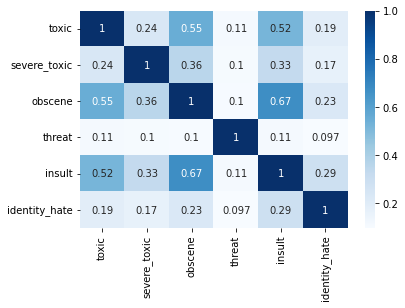

In [155]:
# Let's check the correlations among the target variables.
# We can see that the following labels are highly correlated:
# obscene-insult => 0.67
# obscene-toxic => 0.55
# insult-toxic => 0.52
corr = train_data[target_classes].corr()
sb.heatmap(corr, cmap="Blues", annot=True)

## Pre-process data

In [156]:
# Let's copy the dataset
test_data = test_df.copy()

In [157]:
nltk.download('omw-1.4')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lemmatizing the texts
    # removing aphostrophe words
    text = text.lower() if pd.notnull(text) else text
    text = re.sub(r"what's", "what is ",str(text)) 
    text = re.sub(r"'s", " ", str(text)) 
    text = re.sub(r"'ve", " have ", str(text)) 
    text = re.sub(r"can't", "cannot ", str(text)) 
    text = re.sub(r"ain't", 'is not', str(text)) 
    text = re.sub(r"won't", 'will not', str(text)) 
    text = re.sub(r"n't", " not ", str(text)) 
    text = re.sub(r"i'm", "i am ", str(text)) 
    text = re.sub(r"'re", " are ", str(text)) 
    text = re.sub(r"'d", " would ", str(text)) 
    text = re.sub(r"'ll", " will ", str(text)) 
    text = re.sub(r"'scuse", " excuse ", str(text)) 
    text = re.sub('W', ' ', str(text)) 
    text = re.sub(' +', ' ', str(text))
    # Remove punctuations, numbers and special characters
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text))
    text = text.strip(' ')
    return text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [158]:
# Let's clean up the comment_text in train
train_data['comment_text'] = train_data['comment_text'].map(lambda comment : clean_text(comment))
# Let's clean up the comment_text in test
test_data['comment_text'] = test_data['comment_text'].map(lambda comment : clean_text(comment))

In [159]:
test_data["label"] = test_data.iloc[:,2:8].apply(lambda x: "positive" if (sum(x)==0) else "negative", axis=1)

In [160]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0,negative
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0,positive
12,0005c987bdfc9d4b,hey what is it talk what is it an exclusive gr...,1,0,0,0,0,0,negative
15,00078f8ce7eb276d,juelz santanas age in 2002 juelz santana was 1...,0,0,0,0,0,0,positive
16,0007e25b2121310b,bye do not look come or think of comming back ...,1,0,0,0,0,0,negative


## Train model

In [161]:
# Create feature vectors
vectorizer = TfidfVectorizer(max_features=2,
                             stop_words = 'english',
                             sublinear_tf = True,
                             use_idf = True)

# pickling the vectorizer
pickle.dump(vectorizer, open('/content/drive/MyDrive/ML/vectorizer.pickle', 'wb'))

train_vectors = vectorizer.fit_transform(train_data['comment_text'])
test_vectors = vectorizer.transform(test_data['comment_text'])

In [162]:
import time
from sklearn import svm
from sklearn.metrics import classification_report

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, train_data['label'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(test_data['label'], prediction_linear, output_dict=True)
print('results: ', report)

Training time: 14.166462s; Prediction time: 29.086505s


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


results:  {'negative': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'positive': {'precision': 1.0, 'recall': 0.966682771408425, 'f1-score': 0.9830591750352726, 'support': 153164}, 'accuracy': 0.966682771408425, 'macro avg': {'precision': 0.5, 'recall': 0.4833413857042125, 'f1-score': 0.4915295875176363, 'support': 153164}, 'weighted avg': {'precision': 1.0, 'recall': 0.966682771408425, 'f1-score': 0.9830591750352726, 'support': 153164}}


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
pickle.dump(classifier_linear, open(f'/content/drive/MyDrive/ML/emotion_classifier.model', 'wb'))

## Evaluate model

In [164]:
#text = "::::Well, it sucks to have a university to be nicknameless. And it's the first time in NCAA history that it has happened. /"
#text = "Hello, how are you?"
text = "/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior."
text = clean_text(text)
text_vector = vectorizer.transform([text])

classifier = pickle.load(open('/content/drive/MyDrive/ML/emotion_classifier.model', 'rb'))
result = classifier.predict(text_vector)
print("classifier:", result[0])

classifier: positive
